In [7]:
import os
import datafed
from datafed.CommandLib import API
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import zipfile

In [5]:
# This is a dataGet Command
try:
    datapath = os.mkdir("./datapath")
except:
    datapath = "./datapath"
df_api = API()
true_path = (os.path.abspath(datapath))

c:\Users\willi\Anaconda3\envs\PokemonIdentifier\Lib\site-packages\datafed\Connection.py:200: UserWarning: reflection.ParseMessage() is deprecated. Please use MessageFactory.GetMessageClass() and message.ParseFromString() instead. reflection.ParseMessage() will be removed in Jan 2025.
  reply = google.protobuf.reflection.ParseMessage(desc, data)
c:\Users\willi\Anaconda3\envs\PokemonIdentifier\Lib\site-packages\google\protobuf\reflection.py:59: UserWarning: reflection.MakeClass() is deprecated. Please use MessageFactory.GetMessageClass() instead. reflection.MakeClass() will be removed in Jan 2025.
  result_class = MakeClass(descriptor)


In [ ]:
dget_resp = df_api.dataGet("d/525645423", os.path.abspath(datapath), wait=True)
dget_resp

In [ ]:
def unzip_folder(folder_path, zip_file_name, extract_to=None):
    """
    Unzips a .zip file in the given folder and deletes the .zip file afterwards.
    
    :param folder_path: Path to the folder containing the .zip file.
    :param zip_file_name: Name of the .zip file (with extension).
    :param extract_to: Path to extract the contents to (default: same as folder_path).
    """
    zip_path = os.path.join(folder_path, zip_file_name)  # Full path to the zip file
    
    # Default extraction path is the folder containing the zip file
    if extract_to is None:
        extract_to = folder_path
    
    # Check if the .zip file exists
    if not os.path.exists(zip_path):
        raise FileNotFoundError(f"The file {zip_file_name} was not found in {folder_path}")
    
    # Unzipping the file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print(f"Extracted {zip_file_name} to {extract_to}")
    
    try:
        os.remove(zip_path)
        print(f"Deleted the zip file: {zip_file_name}")
    except OSError as e:
        print(f"Error while deleting the zip file: {e}")


# Example usage
zip_file_name = "PokemonDataset_120824.zip"     # Replace with the name of your .zip file
unzip_folder(true_path, zip_file_name)
images_path = os.path.join(true_path, "PokemonDataset_120824")

Extracted PokemonDataset_120824.zip to c:\Users\willi\Documents\Drexel\Fall Quart 5\MEM 679 - Machine Learning\PokemonIdentifier-3\PokemonIdentifier\src\MachineLearningModel\datapath


In [14]:
# Define constants
#IMAGE_DIR = "/home/jovyan/datapath/PokemonDataset_768By1666"
IMAGE_DIR = images_path
IMG_SIZE = (224, 224) #Images will be resized to 244 x 244
BATCH_SIZE = 32 #Number of images to process at a time
print(IMAGE_DIR)

c:\Users\willi\Documents\Drexel\Fall Quart 5\MEM 679 - Machine Learning\PokemonIdentifier-3\PokemonIdentifier\src\MachineLearningModel\datapath\PokemonDataset_120824


In [15]:
# Function to parse labels from filenames
def parse_filename(filename):
    """
    Parses the filename to extract metadata.

    Args:
        filename (str): The name of the image file.

    Returns:
        pokemon_name (str): Name of Pokemon
        shiny_form (int): 1 if Pokemon is shiny, 0 if Pokemon is Normal
        gender (str): Gender of Pokemon

    """
    parts = filename.replace('.jpg', '').split(' ')
    location_name = parts[0]
    shiny = 1 if 'Shiny' in parts else 0
    gender = 'Unknown'
    if 'Male & Female' in filename:
        gender = 'Male & Female'
    elif 'Male' in filename:
        gender = 'Male'
    elif 'Female' in filename:
        gender = 'Female'
    
    location, name = location_name.split('_', 1)
    
    return name, shiny, gender

In [16]:
# Load dataset
data = []
labels_name = []
labels_shiny = []
labels_gender = []

for file in os.listdir(IMAGE_DIR):
    if file.endswith((".jpg")):
        filepath = os.path.join(IMAGE_DIR, file)
        name, shiny, gender = parse_filename(file)
        data.append(filepath)
        labels_name.append(name)
        labels_shiny.append(shiny)
        labels_gender.append(gender)

In [17]:
# Preprocess labels
unique_names = sorted(set(labels_name))
unique_genders = ["Male", "Female", "Male & Female"]

name_to_idx = {name: i for i, name in enumerate(unique_names)}
gender_to_idx = {gender: i for i, gender in enumerate(unique_genders)}

y_name = [name_to_idx[name] for name in labels_name]
y_shiny = labels_shiny
y_gender = [gender_to_idx[gender] for gender in labels_gender]

# Split data
train_data, val_data, train_labels, val_labels = train_test_split(
    data, list(zip(y_name, y_shiny, y_gender)), test_size=0.2, random_state=42
)

In [18]:
# Preprocess images
'''
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
'''
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)


def preprocess_images(filepaths, labels, batch_size):
    def generator():
        for filepath, label in zip(filepaths, labels):
            # Load the image
            image = tf.keras.utils.load_img(filepath)
            image = tf.keras.utils.img_to_array(image) / 255.0
            # Resize with padding
            image = tf.image.resize_with_pad(image, target_height=IMG_SIZE[0], target_width=IMG_SIZE[1])
            # Restructure labels into a dictionary for model outputs
            label_dict = {
                "name_output": label[0],
                "shiny_output": label[1],
                "gender_output": label[2]
            }
            yield image, label_dict
    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(*IMG_SIZE, 3), dtype=tf.float32),
            {
                "name_output": tf.TensorSpec(shape=(), dtype=tf.int32),
                "shiny_output": tf.TensorSpec(shape=(), dtype=tf.int32),
                "gender_output": tf.TensorSpec(shape=(), dtype=tf.int32),
            },
        )
    ).batch(batch_size)

train_dataset = preprocess_images(train_data, train_labels, BATCH_SIZE)
val_dataset = preprocess_images(val_data, val_labels, BATCH_SIZE)

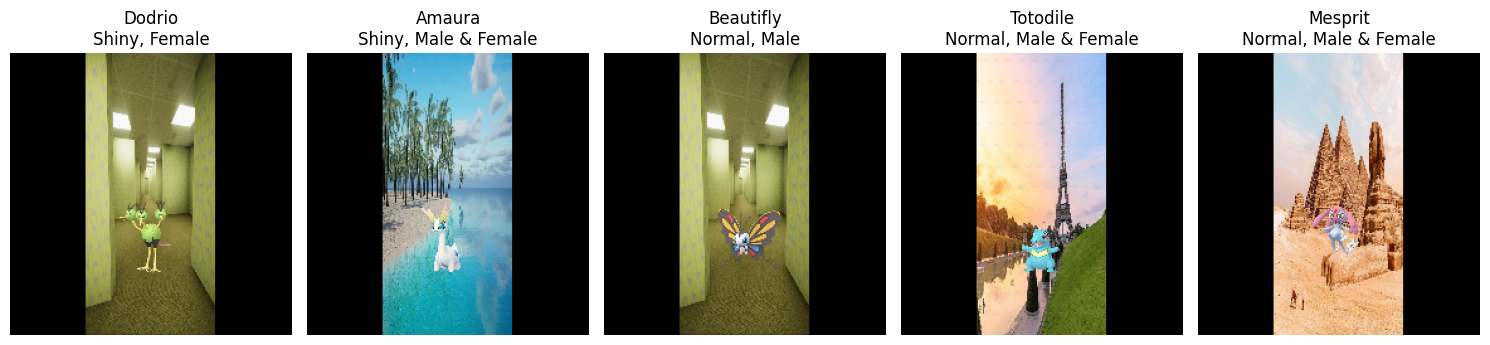

In [19]:
def visualize_preprocessed_images(dataset, num_images=5):
    """
    Visualizes a few random preprocessed images from the dataset.

    Args:
        dataset: A TensorFlow Dataset object containing preprocessed images and labels.
        num_images: Number of images to visualize.
    """
    plt.figure(figsize=(15, 5))
    for i, (image_batch, label_batch) in enumerate(dataset.take(1)):  # Take one batch from the dataset
        for j in range(num_images):
            plt.subplot(1, num_images, j + 1)
            plt.imshow(image_batch[j].numpy())
            plt.axis('off')
            # Display the labels for the first image in the batch
            label = label_batch
            name = label["name_output"][j].numpy()
            shiny = "Shiny" if label["shiny_output"][j].numpy() == 1 else "Normal"
            gender = unique_genders[label["gender_output"][j].numpy()]
            plt.title(f"{unique_names[name]}\n{shiny}, {gender}")
        break  # Only process the first batch
    plt.tight_layout()
    plt.show()

visualize_preprocessed_images(train_dataset)

In [ ]:
# Build the model
base_model = EfficientNetB0(include_top=False, input_shape=(*IMG_SIZE, 3))
x = Flatten()(base_model.output)
x = Flatten()(base_model.output)
x = Dropout(0.5)(x)  # First dropout
x = Dense(512, activation='relu')(x) #THESE WERE ADDITIONAL
x = Dropout(0.3)(x)  # Second dropout #THESE WERE ADDITIONAL


# Add regularization to the Dense layers
name_output = Dense(len(unique_names), activation="softmax", name="name_output",
                    kernel_regularizer=l2(0.02))(x)
shiny_output = Dense(1, activation="sigmoid", name="shiny_output",
                     kernel_regularizer=l2(0.02))(x)
gender_output = Dense(len(unique_genders), activation="softmax", name="gender_output",
                      kernel_regularizer=l2(0.02))(x)

# Final model
model = Model(inputs=base_model.input, outputs=[name_output, shiny_output, gender_output])

In [21]:
# Check available devices
physical_devices = tf.config.list_physical_devices()
for device in physical_devices:
    print(device)

# Check if a GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available and being used.")
else:
    print("GPU not available, using CPU.")

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
GPU not available, using CPU.


In [22]:
# Train the model
model.compile(
    optimizer="adam",
    loss={
        "name_output": "sparse_categorical_crossentropy",
        "shiny_output": "binary_crossentropy",
        "gender_output": "sparse_categorical_crossentropy",
    },
    metrics={
        "name_output": ["accuracy"],
        "shiny_output": ["accuracy"],
        "gender_output": ["accuracy"],
    }
)


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=2, min_lr=1e-6
)


history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/50
      1/Unknown 45s 45s/step - gender_output_accuracy: 0.5312 - gender_output_loss: 1.4299 - loss: 22.7237 - name_output_accuracy: 0.0000e+00 - name_output_loss: 7.7224 - shiny_output_accuracy: 0.4688 - shiny_output_loss: 0.9609

KeyboardInterrupt: 

In [ ]:
#Save the entire model
model.save("pokemon_identifier_model.h5")

In [ ]:
def plot_training_history(history):
    # Extract history metrics
    history_dict = history.history

    # Outputs to plot
    outputs = ['name_output', 'shiny_output', 'gender_output']

    # Create a separate plot for each output
    for output in outputs:
        train_acc = history_dict[f"{output}_accuracy"]
        val_acc = history_dict[f"val_{output}_accuracy"]

        plt.figure(figsize=(10, 6))
        plt.plot(train_acc, label=f"Train {output} Accuracy")
        plt.plot(val_acc, label=f"Validation {output} Accuracy")
        plt.title(f"Training vs. Validation Accuracy for {output.capitalize()}")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)
        plt.show()

    # Plot learning rate vs. epochs
    if 'learning_rate' in history_dict:
        learning_rate = history_dict['learning_rate']
        plt.figure(figsize=(10, 6))
        plt.plot(learning_rate, label="Learning Rate")
        plt.title("Learning Rate vs. Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Learning Rate")
        plt.legend()
        plt.grid(True)
        plt.show()

# Call the function with your history object
plot_training_history(history)


In [ ]:
def load_model_and_predict(model_path, image_path, img_size, class_names, gender_labels):
    """
    Loads a trained model from a .h5 file and predicts the Pokémon's details from an image.

    Args:
        model_path (str): Path to the saved model (.h5 file).
        image_path (str): Path to the image for prediction.
        img_size (tuple): Target size for resizing the image (height, width).
        class_names (list): List of Pokémon names corresponding to model output indices.
        gender_labels (list): List of gender labels corresponding to model output indices.

    Returns:
        dict: Prediction results with Pokémon name, shiny status, and gender.
    """
    # Load the model
    model = tf.keras.models.load_model(model_path)
    print(f"Model loaded from {model_path}")

    # Preprocess the image (resizing with padding and normalization)
    image = tf.keras.utils.load_img(image_path)
    image_array = tf.keras.utils.img_to_array(image) / 255.0  # Normalize to [0, 1]
    image_array = tf.image.resize_with_pad(image_array, target_height=img_size[0], target_width=img_size[1])
    image_array = tf.expand_dims(image_array, axis=0)  # Add batch dimension

    # Make predictions
    predictions = model.predict(image_array)

    # Decode predictions
    name_idx = tf.argmax(predictions[0], axis=1).numpy()[0]
    shiny_status = int(predictions[1][0] > 0.5)  # Binary classification for shiny
    gender_idx = tf.argmax(predictions[2], axis=1).numpy()[0]

    # Prepare the result
    result = {
        "name": class_names[name_idx],
        "shiny": "Shiny" if shiny_status == 1 else "Normal",
        "gender": gender_labels[gender_idx]
    }
    return result

test_image_path = "./BrotherAndPokemon.jpg"  # Replace with your test image path
model_path = "pokemon_classifier_766By1666.h5"

prediction = load_model_and_predict(model_path, test_image_path, IMG_SIZE, unique_names, unique_genders)
print(prediction)